In [1]:
from rs_graph.db import models as db_models
from rs_graph.db.utils import get_engine
from sqlmodel import Session, select
import pandas as pd
import seaborn as sns
import opinionated
import colormaps as cmaps
import matplotlib.pyplot as plt

plt.style.use("opinionated_rc")

# get a dataset of linked repos and papers
data = []
engine = get_engine()
with Session(engine) as session:
    statement = select(
        db_models.DocumentRepositoryLink,
        db_models.Document,
        db_models.Repository,
    ).join(
        db_models.Document,
    ).join(
        db_models.Repository,
    )

    # For each one, we need to get count of contributors for document and repository
    for link, document, repository in session.exec(statement):
        # Also keep track of how many of each type by position their are
        # i.e. how many first authors are matched to devs,
        # how many middle authors are matched to devs, etc.

        # Create and exec doc statement
        doc_contrib_statement = select(db_models.DocumentContributor).where(
            db_models.DocumentContributor.document_id == document.id
        )
        doc_contribs = list(session.exec(doc_contrib_statement))
        doc_contribs_lut = {contrib.id: contrib for contrib in doc_contribs}

        # Create and exec repo statement
        repo_contrib_statement = select(db_models.RepositoryContributor).where(
            db_models.RepositoryContributor.repository_id == repository.id
        )
        repo_contribs = list(session.exec(repo_contrib_statement))
        repo_contribs_lut = {contrib.id: contrib for contrib in repo_contribs}

        # For each doc contrib, check if linked to repo contrib
        matched_contribs_by_position = {}
        for doc_contrib in doc_contribs:
            for repo_contrib in repo_contribs:
                this_doc_contrib_repo_contribs_statement = select(
                    db_models.ResearcherDeveloperAccountLink
                ).where(
                    (
                        db_models.ResearcherDeveloperAccountLink.researcher_id
                        == doc_contrib.researcher_id
                    )
                ).where(
                    (
                        db_models.ResearcherDeveloperAccountLink.developer_account_id
                        == repo_contrib.developer_account_id
                    )
                )
                matched_contrib = session.exec(this_doc_contrib_repo_contribs_statement).first()
                if matched_contrib:
                    position = doc_contrib.position
                    if position not in matched_contribs_by_position:
                        matched_contribs_by_position[position] = []
                    matched_contribs_by_position[position].append(matched_contrib)

        # Calc all n_contribs
        n_doc_contributors = len(doc_contribs)
        n_repo_contributors = len(repo_contribs)
        n_matched_contributors = sum([len(v) for v in matched_contribs_by_position.values()])
        n_matched_contribs_by_position = {
            f"n_matched_{k}_position_contributors": len(v) for k, v in matched_contribs_by_position.items()
        }

        # Get the primary field (field with highest "score" attribute in document topic)
        try:
            primary_document_topic_stmt = select(db_models.DocumentTopic).where(
                db_models.DocumentTopic.document_id == document.id
            ).order_by(db_models.DocumentTopic.score.desc()).limit(1)
            primary_document_topic = session.exec(primary_document_topic_stmt).first()

            # Resolve to field name by querying for document
            primary_topic_stmt = select(db_models.Topic).where(
                db_models.Topic.id == primary_document_topic.topic_id
            )
            primary_topic = session.exec(primary_topic_stmt).first()
        except:
            continue

        # Append to data
        data.append(
            {
                "document_id": document.id,
                "paper_doi": document.doi,
                "publication_date": document.publication_date,
                "cited_by_count": document.cited_by_count,
                "cited_by_percentile_year_min": document.cited_by_percentile_year_min,
                "field": primary_topic.field_name,
                "repository_id": repository.id,
                "owner": repository.owner,
                "name": repository.name,
                "forks_count": repository.forks_count,
                "stargazers_count": repository.stargazers_count,
                "watchers_count": repository.watchers_count,
                "open_issues_count": repository.open_issues_count,
                "size_kb": repository.size_kb,
                "creation_datetime": repository.creation_datetime,
                "last_pushed_datetime": repository.last_pushed_datetime,
                "n_doc_contributors": n_doc_contributors,
                "n_repo_contributors": n_repo_contributors,
                "n_matched_contributors": n_matched_contributors,
                **n_matched_contribs_by_position,
            }
        )

data = pd.DataFrame(data)
data = data.fillna(0)
data.sample(3)

Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

,document_id,paper_doi,publication_date,cited_by_count,cited_by_percentile_year_min,field,repository_id,owner,name,forks_count,...,open_issues_count,size_kb,creation_datetime,last_pushed_datetime,n_doc_contributors,n_repo_contributors,n_matched_contributors,n_matched_first_position_contributors,n_matched_last_position_contributors,n_matched_middle_position_contributors
424,425,10.1371/journal.pone.0280979,2023-05-17,0,0,Mathematics,424,kjamessoda,covasim,0,...,0,12632,2020-05-25 00:10:18,2023-01-11 22:54:49,4,30,0,0.0,0.0,0.0
51,52,10.1371/journal.ppat.1010592,2022-06-29,15,96,Medicine,52,jbloomlab,sars-cov-2-rbd_delta,2,...,0,345340,2021-10-26 00:10:12,2022-12-09 23:02:55,11,2,2,1.0,0.0,1.0
302,303,10.1371/journal.pcbi.1011516,2024-04-16,0,0,Neuroscience,303,wang-yu-hao,basalgangliaexploration,0,...,0,16415,2024-03-30 10:04:24,2024-03-30 10:06:34,4,1,1,1.0,0.0,0.0


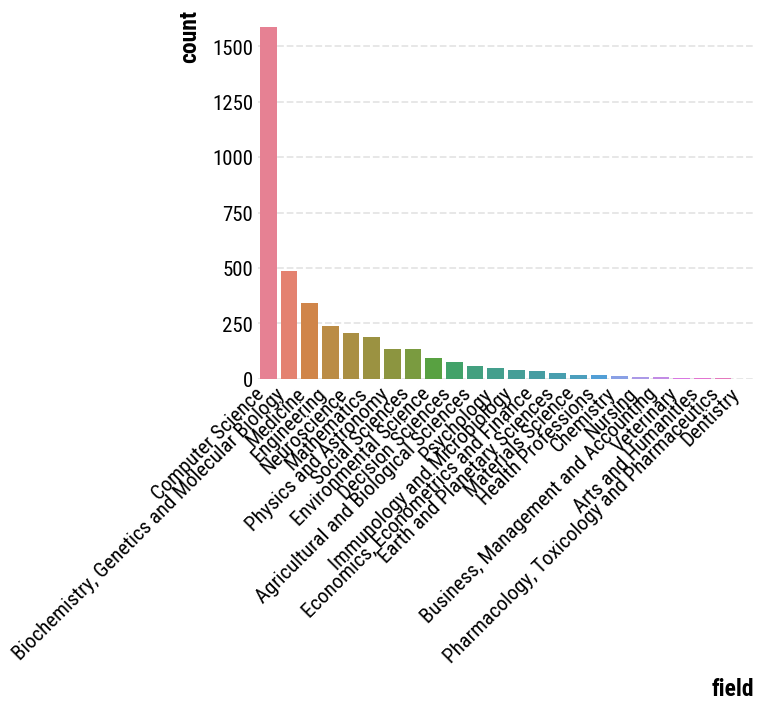

In [2]:
# count plot of fields
field_counts = data["field"].value_counts().reset_index().sort_values("count", ascending=False)
sns.barplot(data=field_counts, x="field", y="count", hue="field")
_ = plt.xticks(rotation=45, ha="right")

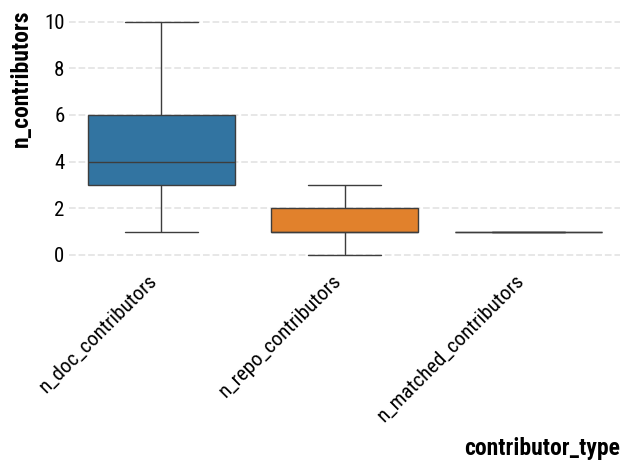

In [3]:
# Melt metrics
data_melted = pd.melt(
    data,
    id_vars="document_id",
    value_vars=[
        "n_doc_contributors",
        "n_repo_contributors",
        "n_matched_contributors",
    ],
    var_name="contributor_type",
    value_name="n_contributors",
)

ax = sns.boxplot(
    data=data_melted,
    x="contributor_type",
    y="n_contributors",
    hue="contributor_type",
    showfliers=False,
)
_ = plt.xticks(rotation=45, ha="right")
plt.tight_layout()

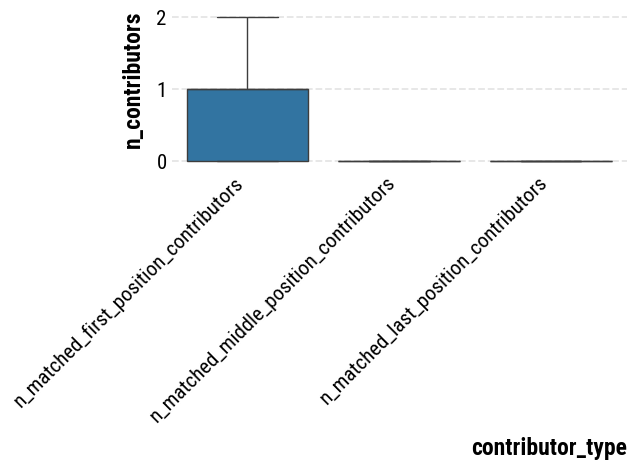

In [4]:
# Melt metrics
data_melted = pd.melt(
    data,
    id_vars="document_id",
    value_vars=[
        "n_matched_first_position_contributors",
        "n_matched_middle_position_contributors",
        "n_matched_last_position_contributors",
    ],
    var_name="contributor_type",
    value_name="n_contributors",
)

ax = sns.boxplot(
    data=data_melted,
    x="contributor_type",
    y="n_contributors",
    hue="contributor_type",
    showfliers=False,
)
_ = plt.xticks(rotation=45, ha="right")
plt.tight_layout()

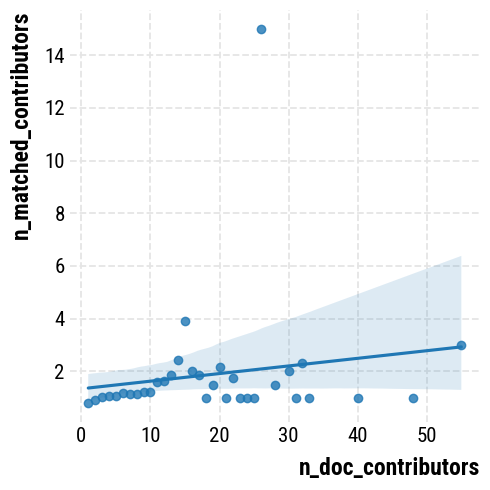

In [5]:
# Group by n doc contributors and take mean of n matched contributors
data_grouped = data.groupby("n_doc_contributors").agg(
    {"n_matched_contributors": "mean"}
).reset_index()

sns.lmplot(
    data=data_grouped,
    x="n_doc_contributors",
    y="n_matched_contributors",
)

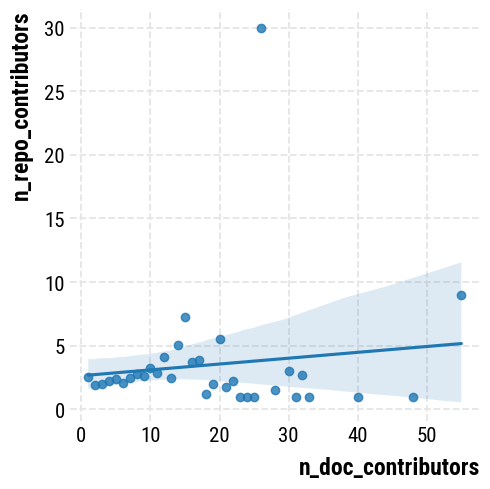

In [6]:
# same thing but with repo contributors
data_grouped = data.groupby("n_doc_contributors").agg(
    {"n_repo_contributors": "mean"}
).reset_index()

sns.lmplot(
    data=data_grouped,
    x="n_doc_contributors",
    y="n_repo_contributors",
)

<Axes: xlabel='n_doc_contributors', ylabel='n_matched_contributors_norm'>

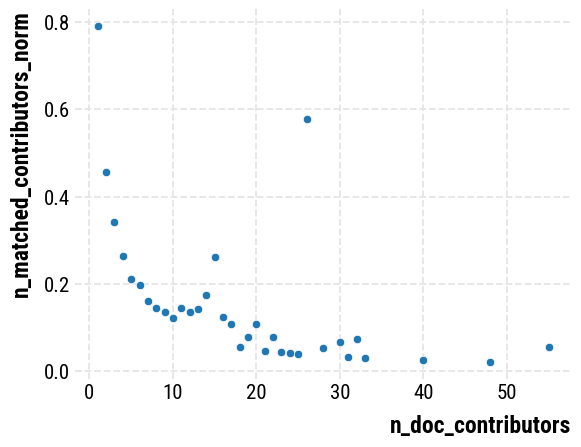

In [7]:
# Same thing but norm by n_doc_contributors
data["n_matched_contributors_norm"] = data["n_matched_contributors"] / data["n_doc_contributors"]

# Groupby n doc contributors and take mean of n matched contributors
data_grouped = data.groupby("n_doc_contributors").agg(
    {"n_matched_contributors_norm": "mean"}
).reset_index()

sns.scatterplot(
    data=data_grouped,
    x="n_doc_contributors",
    y="n_matched_contributors_norm",
)

<Axes: xlabel='n_doc_contributors', ylabel='n_repo_contributors_norm'>

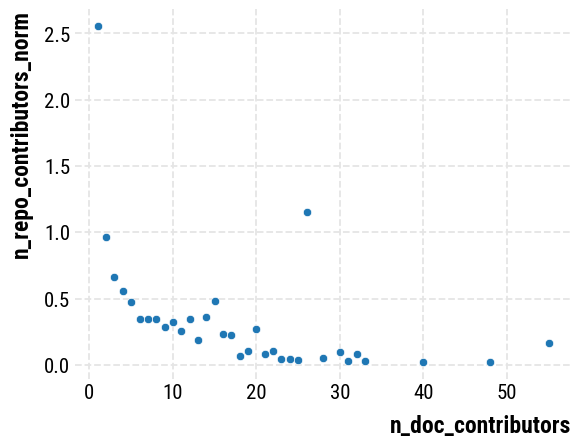

In [8]:
# same thing but with repo contributors
data["n_repo_contributors_norm"] = data["n_repo_contributors"] / data["n_doc_contributors"]
data_grouped = data.groupby("n_doc_contributors").agg(
    {"n_repo_contributors_norm": "mean"}
).reset_index()

sns.scatterplot(
    data=data_grouped,
    x="n_doc_contributors",
    y="n_repo_contributors_norm",
)

<Axes: xlabel='publication_date', ylabel='n_contributors'>

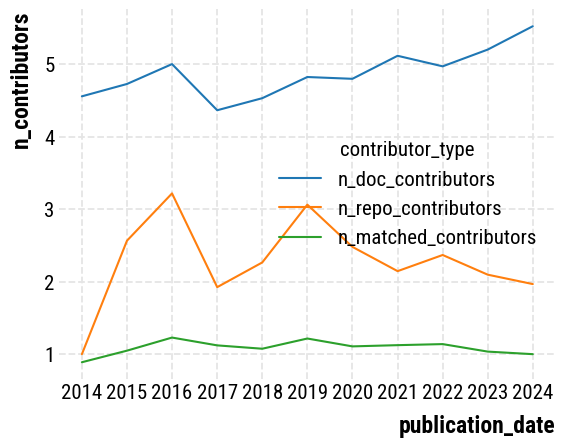

In [9]:
data["publication_date"] = pd.to_datetime(data["publication_date"])

# For each month, take the mean of each contributor type
data["publication_year"] = data["publication_date"].dt.to_period("Y")
data_grouped = data.groupby(["publication_year"]).agg(
    {
        "publication_date": "min",
        "n_doc_contributors": "mean",
        "n_repo_contributors": "mean",
        "n_matched_contributors": "mean",
    }
).reset_index()

data_grouped = pd.melt(
    data_grouped,
    id_vars=["publication_year", "publication_date"],
    value_vars=[
        "n_doc_contributors",
        "n_repo_contributors",
        "n_matched_contributors",
    ],
    var_name="contributor_type",
    value_name="n_contributors",
)

sns.lineplot(
    data=data_grouped,
    x="publication_date",
    y="n_contributors",
    hue="contributor_type",
)

In [10]:
# Create column for "duration between repo creation date and document publication date"
data["duration_to_publication"] = data["publication_date"] - data["creation_datetime"]

# Create column for "duration between repo last push date and document publication date"
data["duration_to_last_push"] = data["publication_date"] - data["last_pushed_datetime"]

# Create column for "duration commit activity"
data["duration_commit_acitivity"] = data["last_pushed_datetime"] - data["creation_datetime"]

data.sample(3)

,document_id,paper_doi,publication_date,cited_by_count,cited_by_percentile_year_min,field,repository_id,owner,name,forks_count,...,n_matched_contributors,n_matched_first_position_contributors,n_matched_last_position_contributors,n_matched_middle_position_contributors,n_matched_contributors_norm,n_repo_contributors_norm,publication_year,duration_to_publication,duration_to_last_push,duration_commit_acitivity
1675,1676,10.48550/arxiv.1902.06056,2019-01-01,0,0,Computer Science,1667,ankushdas,nomos,3,...,4,1.0,1.0,2.0,0.8,1.0,2019,-163 days +06:44:34,-1375 days +15:52:52,1211 days 14:51:42
1716,1717,10.48550/arxiv.2306.00658,2023-01-01,0,0,Engineering,1708,keeganhk,neurogf,0,...,1,1.0,0.0,0.0,0.2,0.2,2023,-152 days +11:01:54,-331 days +08:00:12,179 days 03:01:42
2411,2412,10.48550/arxiv.2201.08951,2022-01-01,0,0,Computer Science,2403,autovision-cloud,ssl-vit-lowlabel-highdata,2,...,1,1.0,0.0,0.0,0.2,0.2,2022,75 days 19:21:34,-125 days +01:19:14,200 days 18:02:20


<Axes: xlabel='duration_to_publication'>

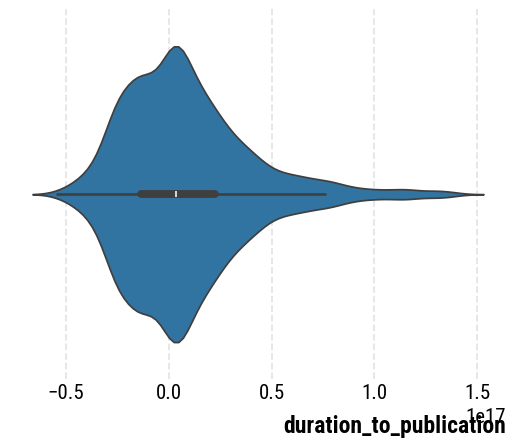

In [11]:
# Distribution of duration_to_publication
# Removing top 1% and bottom 1% of data
sns.violinplot(data=data.loc[
    data["duration_to_publication"].between(
            data["duration_to_publication"].quantile(0.01),
            data["duration_to_publication"].quantile(0.99),
        )
    ],
    x="duration_to_publication",
)

In [12]:
data.loc[data["duration_to_publication"].between(
    data["duration_to_publication"].quantile(0.01),
    data["duration_to_publication"].quantile(0.99),
)].duration_to_publication.describe()

count                           3701
mean      97 days 07:56:05.369089435
std      361 days 03:59:45.396750648
min              -626 days +04:05:39
25%              -156 days +16:10:34
50%                 42 days 02:07:36
75%                258 days 14:28:01
max               1631 days 07:41:43
Name: duration_to_publication, dtype: object

<Axes: xlabel='duration_to_last_push'>

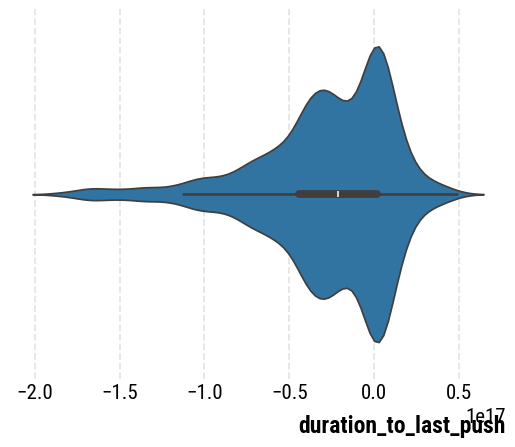

In [13]:
sns.violinplot(data=data.loc[
    data["duration_to_last_push"].between(
            data["duration_to_last_push"].quantile(0.01),
            data["duration_to_last_push"].quantile(0.99),
        )
    ],
    x="duration_to_last_push",
)

In [14]:
data.loc[data["duration_to_last_push"].between(
    data["duration_to_last_push"].quantile(0.01),
    data["duration_to_last_push"].quantile(0.99),
)].duration_to_publication.describe()

count                           3701
mean      95 days 00:25:07.948122130
std      404 days 19:38:00.921747792
min             -2123 days +16:09:28
25%              -160 days +12:23:05
50%                 38 days 09:58:27
75%                253 days 20:21:08
max               2909 days 00:58:28
Name: duration_to_publication, dtype: object

In [15]:
# Find rows with duplicate repository_id
dup_repos = data[data.duplicated(subset=["repository_id"], keep=False)]
for repo, group in dup_repos.groupby("repository_id"):
    # get repo owner and name from first row
    owner = group.iloc[0]["owner"]
    name = group.iloc[0]["name"]
    print(f"https://github.com/{owner}/{name}")
    for paper_doi in group["paper_doi"]:
        print(f"https://doi.org/{paper_doi}")
    print()
    print()


https://github.com/owid/covid-19-data
https://doi.org/10.1371/journal.pone.0247512
https://doi.org/10.1371/journal.pone.0279022
https://doi.org/10.1371/journal.pone.0271220


https://github.com/nytimes/covid-19-data
https://doi.org/10.1371/journal.pmed.1003693
https://doi.org/10.1371/journal.pone.0278515


https://github.com/cmu-delphi/delphi-epidata
https://doi.org/10.1371/journal.pone.0260731
https://doi.org/10.1371/journal.pcbi.1006599


https://github.com/cssegisanddata/covid-19
https://doi.org/10.1371/journal.pone.0257354
https://doi.org/10.1371/journal.pone.0268332
https://doi.org/10.1371/journal.pone.0231236
https://doi.org/10.1371/journal.pone.0238410
https://doi.org/10.1371/journal.pone.0236776


https://github.com/jgcri/gcam-core
https://doi.org/10.1371/journal.pone.0215013
https://doi.org/10.1371/journal.pone.0237918


https://github.com/tensorflow/models
https://doi.org/10.48550/arxiv.2104.00613
https://doi.org/10.48550/arxiv.1801.03526


https://github.com/google-research/

<Axes: xlabel='duration_commit_acitivity'>

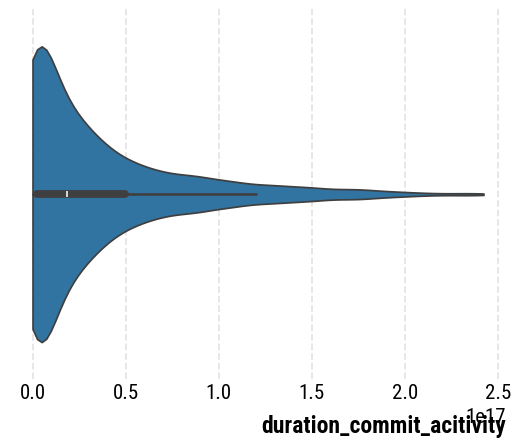

In [16]:
sns.violinplot(
    data=data.loc[
        data["duration_commit_acitivity"].between(
            data["duration_commit_acitivity"].quantile(0.01),
            data["duration_commit_acitivity"].quantile(0.99),
        )
    ],
    x="duration_commit_acitivity",
    cut=0,
)

In [17]:
data.loc[
    data["duration_commit_acitivity"].between(
        data["duration_commit_acitivity"].quantile(0.01),
        data["duration_commit_acitivity"].quantile(0.99),
    )
].duration_commit_acitivity.describe()

count                           3702
mean     413 days 04:19:59.326580224
std      521 days 05:19:52.941295696
min                  0 days 00:01:03
25%          28 days 00:41:44.500000
50%                212 days 17:32:41
75%         576 days 17:03:17.500000
max               2804 days 03:36:12
Name: duration_commit_acitivity, dtype: object

In [18]:
from sklearn.preprocessing import PowerTransformer, StandardScaler

model_data = data[[
    "field",
    "cited_by_count",
    "forks_count",
    "stargazers_count",
    "watchers_count",
    "size_kb",
    "n_doc_contributors",
    "n_repo_contributors",
    "n_matched_contributors",
    "duration_to_publication",
    "duration_commit_acitivity",
]].copy()

# Convert "duration" columns to days
for col in ["duration_to_publication", "duration_commit_acitivity"]:
    model_data[col] = model_data[col].dt.days

# # Remove top 1% and bottom 1% of each metric
# for col in model_data.columns[1:]:
#     q_low = model_data[col].quantile(0.01)
#     q_high = model_data[col].quantile(0.99)
#     model_data = model_data[
#         (model_data[col] > q_low) & (model_data[col] < q_high)
#     ]

# Groupby field, then normalize each metric using log norm
groups = []
for field, group in model_data.groupby("field"):
    group = group.copy()
    for col in model_data.columns[1:]:
        if "duration" in col:
            tr = StandardScaler()
        else:
            tr = PowerTransformer()
        group[col] = tr.fit_transform(group[[col]])
    
    groups.append(group)

model_data = pd.concat(groups)

# remove field column
model_data = model_data.drop(columns=["field"])

<Axes: >

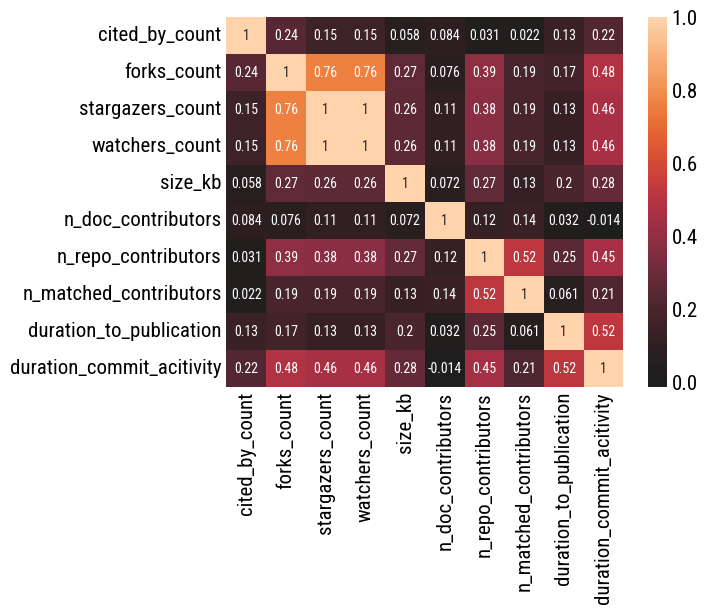

In [19]:
# show correlation across all metrics
corr = model_data.corr()
sns.heatmap(corr, center=0, annot=True)

<Axes: xlabel='publication_year', ylabel='count'>

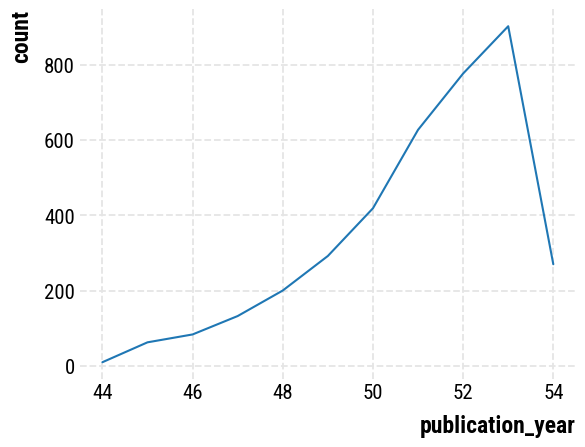

In [20]:
# get count of publications by publication_year
publication_counts = data["publication_year"].value_counts().reset_index()
publication_counts = publication_counts.astype({"publication_year": int})
sns.lineplot(data=publication_counts, x="publication_year", y="count")